# Лабораторная работа №3
## Многослойные сети. Алгоритм обратного распространения ошибки

## Вариант 23
Целью работы является исследование свойств многослойной нейронной сети прямого распространения и алгоритмов ее обучения, применение сети в задачах классификации и аппроксимации функции.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers

Сгенерирую псевдослучайные данные для обучения и тестирования.

In [2]:
def gen_random_ellipse_data(a, b, alpha, x_0, y_0, n):
    rand_nums = 2*np.pi*np.random.rand(n)
    x = x_0 + a * np.cos(rand_nums)
    y = y_0 + b * np.sin(rand_nums)
    xr = x * np.cos(alpha) - y * np.sin(alpha)
    yr = x * np.sin(alpha) + y * np.cos(alpha)
    return np.array([xr, yr])

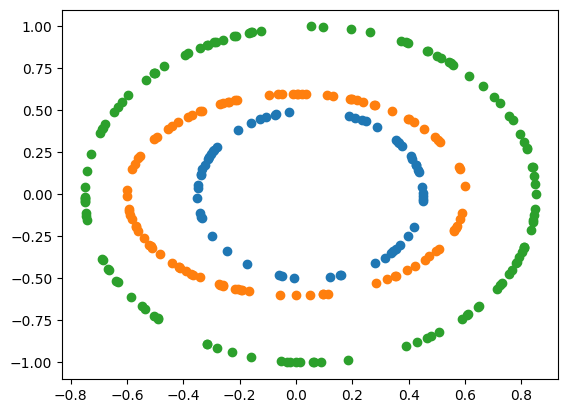

In [3]:
fig, ax = plt.subplots(1, 1)
data1_size = 60
data2_size = 100
data3_size = 120
data1 = gen_random_ellipse_data(0.4, 0.5, 0, 0.05, 0, data1_size)
data2 = gen_random_ellipse_data(0.6, 0.6, 0, 0.00, 0, data2_size)
data3 = gen_random_ellipse_data(0.8, 1, 0, 0.05, 0, data3_size)
ax.scatter(data1[0], data1[1])
ax.scatter(data2[0], data2[1])
ax.scatter(data3[0], data3[1])

plt.show()

Перегруппирую и разобью данные на тестовую и обучающую выборку.

In [4]:
data = np.concatenate([data1, data2, data3], axis=1)
data = data.transpose()
labels1 = np.array([[1, 0, 0] for i in range(data1_size)])
labels2 = np.array([[0, 1, 0] for i in range(data2_size)])
labels3 = np.array([[0, 0, 1] for i in range(data3_size)])
labels = np.concatenate([labels1, labels2, labels3], axis=0)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=322)
# X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.333, random_state=228)

Создам нейросетевую модель. В ней будет два скрытых слоя по 20 нейронов, функцию активации везде гиперболический тангенс.

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(20, input_dim=2, activation='tanh',
                                 kernel_initializer=keras.initializers.RandomNormal(stddev=0.5,mean=0.0),
                                 bias_initializer=keras.initializers.Zeros()))
model.add(keras.layers.Dense(20, input_dim=20, activation='tanh',
                                 kernel_initializer=keras.initializers.RandomNormal(stddev=0.5,mean=0.0),
                                 bias_initializer=keras.initializers.Zeros()))
model.add(keras.layers.Dense(20, input_dim=20, activation='tanh',
                                 kernel_initializer=keras.initializers.RandomNormal(stddev=0.5,mean=0.0),
                                 bias_initializer=keras.initializers.Zeros()))
model.add(keras.layers.Dense(3, input_dim=20, activation='tanh',
                                 kernel_initializer=keras.initializers.RandomNormal(stddev=0.5,mean=0.0),
                                 bias_initializer=keras.initializers.Zeros()))

model.compile(loss='mse', optimizer='sgd', metrics=['mae'])

Обучу модель.

In [6]:
epochs = 200
hist = model.fit(X_train, y_train, batch_size=5, epochs=epochs)

Epoch 1/200
40/40 [==============================] - 2s 7ms/step - loss: 0.6174 - mae: 0.6177
Epoch 2/200
40/40 [==============================] - 0s 7ms/step - loss: 0.4969 - mae: 0.5806
Epoch 3/200
40/40 [==============================] - 0s 8ms/step - loss: 0.4572 - mae: 0.5627
Epoch 4/200
40/40 [==============================] - 0s 7ms/step - loss: 0.3980 - mae: 0.5258
Epoch 5/200
40/40 [==============================] - 0s 7ms/step - loss: 0.2898 - mae: 0.4604
Epoch 6/200
40/40 [==============================] - 0s 7ms/step - loss: 0.2229 - mae: 0.4140
Epoch 7/200
40/40 [==============================] - 0s 7ms/step - loss: 0.1970 - mae: 0.3912
Epoch 8/200
40/40 [==============================] - 0s 7ms/step - loss: 0.1903 - mae: 0.3865
Epoch 9/200
40/40 [==============================] - 0s 7ms/step - loss: 0.1821 - mae: 0.3762
Epoch 10/200
40/40 [==============================] - 0s 7ms/step - loss: 0.1792 - mae: 0.3750
Epoch 11/200
40/40 [==============================] - 0s 7m

Отрисую результат тестирования и области классификации.

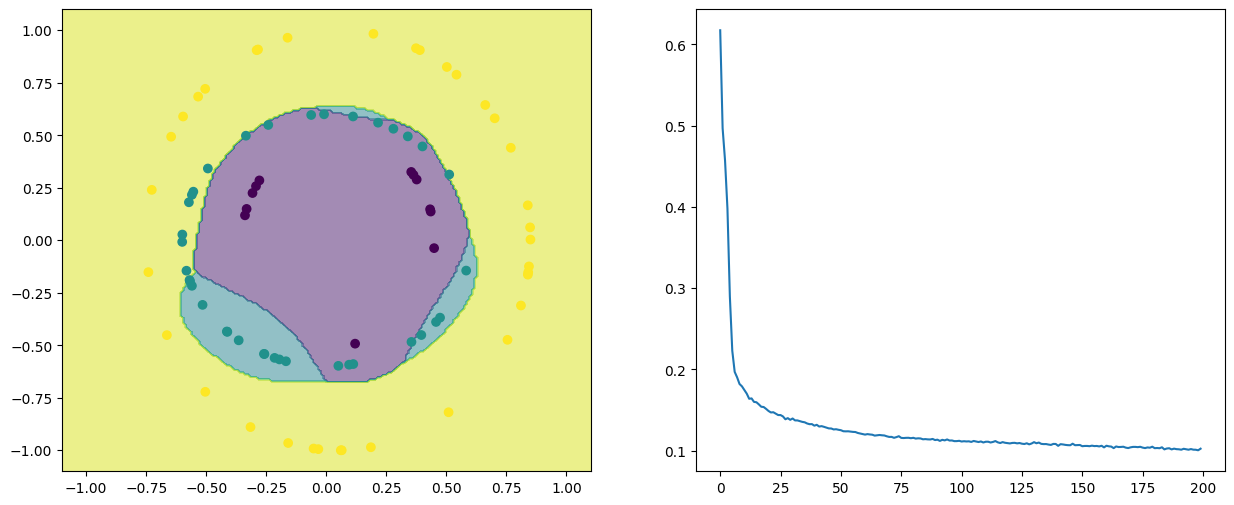

In [7]:
steps = 200
x_span = np.linspace(-1.1, 1.1, steps)
y_span = np.linspace(-1.1, 1.1, steps)
xx, yy = np.meshgrid(x_span, y_span)
grid_points = np.array([xx.ravel(), yy.ravel()])
grid_points = grid_points.transpose()

grid_predictions = model(grid_points)
grid_labels = np.argmax(grid_predictions, axis=1)

predictions = model(X_test)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

grid_labels = grid_labels.reshape(xx.shape)
ax[0].contourf(xx, yy, grid_labels, alpha=0.5)
ax[0].scatter(X_test[:, 0], X_test[:, 1], c=np.argmax(y_test, axis=1))

ax[1].plot(hist.history['loss'])

plt.show()

# Аппроксимация

Задам функцию для аппроксимации, согласно варианту.

In [8]:
def f(t):
    return np.sin(t**2-6*t+3)

x = np.arange(0, 5, 0.025)
y = f(x)

Построю и обучу модель. Модель аналогична предыдущей, за исключением активационной функции между последним скрытым и выходным слоем.

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(20, input_dim=1, activation='tanh',
                                 kernel_initializer=keras.initializers.RandomNormal(stddev=0.5,mean=0.0),
                                 bias_initializer=keras.initializers.Zeros()))
model.add(keras.layers.Dense(20, input_dim=20, activation='tanh',
                                 kernel_initializer=keras.initializers.RandomNormal(stddev=0.5,mean=0.0),
                                 bias_initializer=keras.initializers.Zeros()))
model.add(keras.layers.Dense(20, input_dim=20, activation='tanh',
                                 kernel_initializer=keras.initializers.RandomNormal(stddev=0.5,mean=0.0),
                                 bias_initializer=keras.initializers.Zeros()))
model.add(keras.layers.Dense(1, input_dim=20, activation='linear',
                                 kernel_initializer=keras.initializers.RandomNormal(stddev=0.5,mean=0.0),
                                 bias_initializer=keras.initializers.Zeros()))

model.compile(loss='mse', optimizer='sgd', metrics=['mae'])

In [10]:
epochs = 200
hist = model.fit(x, y, batch_size=1, epochs=epochs)

Epoch 1/200
200/200 [==============================] - 2s 6ms/step - loss: 0.3878 - mae: 0.4935
Epoch 2/200
200/200 [==============================] - 1s 6ms/step - loss: 0.2550 - mae: 0.4062
Epoch 3/200
200/200 [==============================] - 1s 5ms/step - loss: 0.1711 - mae: 0.3108
Epoch 4/200
200/200 [==============================] - 1s 5ms/step - loss: 0.1541 - mae: 0.2958
Epoch 5/200
200/200 [==============================] - 1s 5ms/step - loss: 0.1564 - mae: 0.2952
Epoch 6/200
200/200 [==============================] - 1s 6ms/step - loss: 0.1314 - mae: 0.2634
Epoch 7/200
200/200 [==============================] - 2s 8ms/step - loss: 0.1427 - mae: 0.2838
Epoch 8/200
200/200 [==============================] - 2s 9ms/step - loss: 0.1344 - mae: 0.2712
Epoch 9/200
200/200 [==============================] - 1s 7ms/step - loss: 0.1283 - mae: 0.2676
Epoch 10/200
200/200 [==============================] - 1s 7ms/step - loss: 0.1233 - mae: 0.2479
Epoch 11/200
200/200 [=================

Отрисую результаты предсказаний для тоже самой функции, но по точкам с шагом меньшим в 4 раза, чем для данных для обучения.

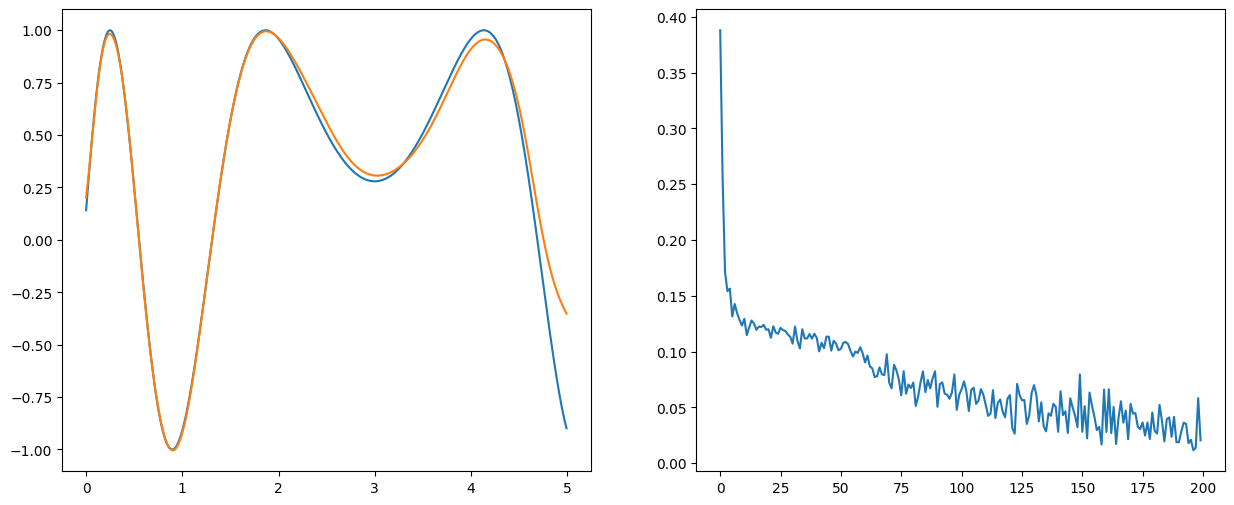

In [11]:
x = np.arange(0, 5, 0.025/4)

predictions = model(x)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(x, f(x))
ax[0].plot(x, predictions)

ax[1].plot(hist.history['loss'])

plt.show()

__Выводы__: в ходе выполнения лабораторной работы я изучил принципы построения и обучения многослойных нейронных сетей. Обучил многослойную  нейросетевую модель для классификации по двум признакам, а также использовал аналогичную модель для аппроксимации функции. В обоих случаях модель показала неплохие результаты.